# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [122]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [123]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [124]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-16 09:00:00+09:00,48107.441406,48201.500000,47955.750000,47955.750000,0,0.0,0.0
2025-10-16 09:15:00+09:00,47955.519531,48135.949219,47955.519531,48135.949219,0,0.0,0.0
2025-10-16 09:30:00+09:00,48130.468750,48130.468750,47965.300781,47965.300781,0,0.0,0.0
2025-10-16 09:45:00+09:00,47958.289062,48026.761719,47937.718750,48021.531250,0,0.0,0.0
2025-10-16 10:00:00+09:00,48030.609375,48107.910156,48002.058594,48002.058594,0,0.0,0.0
2025-10-16 10:15:00+09:00,47983.679688,48059.261719,47974.519531,48009.621094,0,0.0,0.0
2025-10-16 10:30:00+09:00,48011.171875,48079.398438,47987.449219,48045.078125,0,0.0,0.0
2025-10-16 10:45:00+09:00,48045.179688,48048.378906,47968.679688,48017.058594,0,0.0,0.0
2025-10-16 11:00:00+09:00,48014.640625,48056.628906,47980.851562,48034.191406,0,0.0,0.0


## 前日終値の取得

In [125]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-09 00:00:00+09:00    48580.441406
2025-10-10 00:00:00+09:00    48088.800781
2025-10-14 00:00:00+09:00    46847.320312
2025-10-15 00:00:00+09:00    47672.671875
2025-10-16 00:00:00+09:00    48215.980469
Name: Close, dtype: float64


Date
2025-10-15 00:00:00+09:00    47672.671875
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [126]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+434.77


## ローソク足チャート（小さいサイズ）

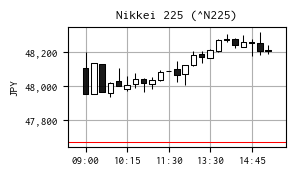

In [127]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [128]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [129]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-15 08:00:00+09:00,151.800003,151.852005,151.779007,151.802994,0,0.0,0.0
2025-10-15 08:15:00+09:00,151.800995,151.830002,151.735001,151.772995,0,0.0,0.0
2025-10-15 08:30:00+09:00,151.774002,151.798996,151.737000,151.738007,0,0.0,0.0
2025-10-15 08:45:00+09:00,151.740997,151.776993,151.688995,151.701996,0,0.0,0.0
2025-10-15 09:00:00+09:00,151.699997,151.824997,151.625000,151.807999,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-16 14:30:00+09:00,151.087997,151.171005,151.082001,151.123001,0,0.0,0.0
2025-10-16 14:45:00+09:00,151.123001,151.141998,151.033997,151.057007,0,0.0,0.0
2025-10-16 15:00:00+09:00,151.050995,151.121994,151.014008,151.018005,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [130]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-16 09:00:00+09:00,319.042362,319.666146,318.036364,318.036364
2025-10-16 09:15:00+09:00,318.448768,319.646912,318.448768,319.646912
2025-10-16 09:30:00+09:00,319.646600,319.646600,318.549678,318.549678
2025-10-16 09:45:00+09:00,318.222039,318.676382,318.085547,318.641676
2025-10-16 10:00:00+09:00,318.682876,319.195766,318.493441,318.493441
2025-10-16 10:15:00+09:00,318.472933,318.974580,318.412136,318.645109
2025-10-16 10:30:00+09:00,318.896686,319.349856,318.739117,319.121895
2025-10-16 10:45:00+09:00,319.033586,319.054830,318.525604,318.846854
2025-10-16 11:00:00+09:00,318.691109,318.969801,318.466838,318.820874


### 前日の終値のドル円レートから、前日の終値のドル換算

In [131]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-15 15:15:00+09:00


np.float64(151.0260009765625)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 315.6587049033911


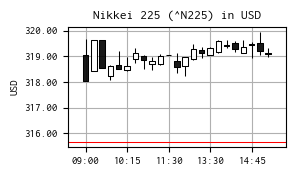

In [132]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()